In [1]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from scipy.stats import linregress

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

'''Import script which contains functions'''
import analysis_functions
from analysis_functions import get_r2
from analysis_functions import get_lassoCV
from analysis_functions import perform_randomizedLasso

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

/home/prubbens/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/prubbens/.local/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Import the dataframes: 

In [2]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
data_rel = pd.read_csv('data/Chloroplasts_removed/nochloro_relative_otu.tsv', sep=' ', index_col=None, header=0)
target = pd.read_table('data/Chloroplasts_removed/recalculated_mean_HNA_LNA_v2.tsv', index_col=0, header=0)
#target_new = pd.read_csv('recalculated_mean_HNA_LNA.csv', index_col=0, header=0)
#productivity = pd.read_table('data/Chloroplasts_removed/productivity_data_v2.tsv', sep=' ', index_col=0, header=0)
#productivity.index = productivity.samples

**2)**: At 01-05-'17 @marschmi found that a few samples can be seen as outliers, as they represent the bottom waters of productive inland lakes, resulting in a big difference of the HNA percentage. These samples are the following: Z14055F, Z14003F, Z14007F, Z14023F, Z14011F. A code of line is added, in order to be able to run the pipeline without these samples; 

In [3]:
samples_to_drop = ['Z14055F', 'Z14003F', 'Z14007F', 'Z14023F', 'Z14011F']
index = target.index.drop(samples_to_drop)
#display(hna_lna.loc[target.loc[index,:].samples,:])

In [4]:
'''Set sample names as index and shuffle data'''
#productivity = productivity.loc[target.samples.values,:]
#productivity.index= target.index

#Remove outlier samples:
data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
#productivity = productivity.loc[index,:]

#Shuffle data: 
data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
#productivity = productivity.sample(frac=1, random_state=3) 

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[:,'LNA.cells']
lna_rel = lna/target.loc[:,'Total.cells']
lna = pd.Series(lna, index=lna.index)
lna_rel = pd.Series(lna_rel, index=lna.index)

**-- PREPROCESSING OF DATA --**

**1)**: filter out those OTUs which have very low abundances and so give rise to (almost) zero-columns. Therefore an OTU has to have a minimal relative abundance one, defined by the parameter $abun$. 

In [5]:
'''Parameter abun for initial filtering of OTUs'''
abun = 0.001

In [6]:
from analysis_functions import preprocess_df_meanabun
data_abs = preprocess_df_meanabun(data_abs,abun,True)
otus = list(data_abs.columns)

print('Number of OTUs: ' + str(len(otus)))

Number of OTUs: 133


(Note that this number is the same whether we use absolute or relative abundances, as the filtering is based on a minimal _relative_ abundance.)

In [12]:
#Some variables to store information and to create inner and outer CV-folds

#cv_out = 10
cv = 5
#outer_cv = KFold(n_splits=cv_out, shuffle=False)

#otu_scores_cv = pd.DataFrame(columns=otus)
#r2_cv = np.zeros(cv_out)
#thresholds_cv = np.zeros(cv_out)

#pred = pd.Series(index=data_abs.index)
#final_scores = pd.DataFrame(columns=otus)

#thresholds = np.arange(0,1,0.01)
#t = 0

In [8]:
''' Standardize data '''
from analysis_functions import standardize_df
data_stand, scaler = standardize_df(data_abs,otus)

To do so, we use the **_Randomized Lasso_**: this method makes use of two kinds of randomization in order to select variables (i.e., OTU's) with a certain _stability_: (1) it fits a Lasso to various bootstrap subsamples and (2) it perturbs the initial weighting of certain variables. 

This results in a $score \in [0,1]$ that is assigned to variables, with 0 denoting the case where a variable is never chosen by the Lasso, and 1 denoting the case where a variable always is chosen. In other words, the higher the score, the more important a variable can be considered to be. 

**First goal: ** try to pinpoint those OTU's for which we are sure they are present in the '_HNA-cloud_'. 

**Univariate Feature Selection**: 

Let's compare two methods: 
- f_regression (f-score pearson correlation), 
- Mutual information,  
- (other methods can follow as well). 

In [13]:
f_regr, f_regr_p = f_regression(data_stand.loc[:,otus],hna)
uni_fs = pd.DataFrame(f_regr, index=otus, columns = ['f_regr'])
uni_fs['p-value'] = f_regr_p
uni_fs['mi'] = mutual_info_regression(data_stand.loc[:,otus],hna)
uni_fs.sort_values(ascending=False,inplace=True, by='f_regr')
display(uni_fs.head(10))

,f_regr,p-value,mi
Otu000009,184.847950,8.957596e-29,0.489672
Otu000025,163.918069,1.519870e-26,0.639668
Otu000060,153.792864,2.052648e-25,0.500501
Otu000173,136.218985,2.309112e-23,0.562660
Otu000011,126.396437,3.658538e-22,0.441922
Otu000004,109.261363,5.729844e-20,0.416705
Otu000010,92.569964,1.083322e-17,0.449151
Otu000007,90.910734,1.858917e-17,0.364228
Otu000024,90.249258,2.307718e-17,0.530094
Otu000020,87.480169,5.742403e-17,0.422348


Select otu's based on $p < \text{thr}$: 

In [14]:
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p-value'].values < 0.05]
print('Number of selected OTUs with p < 0.05: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p-value'].values < 0.01]
print('Number of selected OTUs with p < 0.01: ' + str(len(uni_fs_selected_f)))

Number of selected OTUs with p < 0.05: 98
Number of selected OTUs with p < 0.01: 88


What happens when we tune a threshold in function of the f_score: 

In [15]:
from analysis_functions import get_r2_scores
thr_otu_f_regr_hna, r2_otu_f_regr_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs['f_regr'], cv)
thr_otu_f_regr_lna, r2_otu_f_regr_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs['f_regr'], cv)

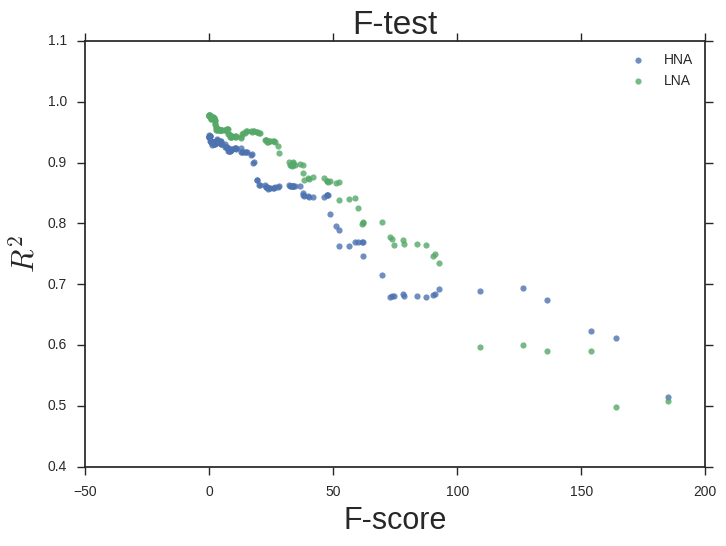

In [16]:
plt.figure()
sns.regplot(x=thr_otu_f_regr_hna,y=r2_otu_f_regr_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_f_regr_lna,y=r2_otu_f_regr_lna, fit_reg=False, label='LNA')
plt.xlabel('F-score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.title('F-test', size=24)
plt.legend()
plt.show()

In [17]:
uni_fs.sort_values(ascending=False,inplace=True, by='mi')
display(uni_fs.head(10))
thr_otu_mi_hna, r2_otu_mi_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs['mi'], cv)
thr_otu_mi_lna, r2_otu_mi_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs['mi'], cv)

,f_regr,p-value,mi
Otu000025,163.918069,1.519870e-26,0.639668
Otu000173,136.218985,2.309112e-23,0.562660
Otu000024,90.249258,2.307718e-17,0.530094
Otu000060,153.792864,2.052648e-25,0.500501
Otu000009,184.847950,8.957596e-29,0.489672
Otu000169,74.428409,4.868765e-15,0.450949
Otu000010,92.569964,1.083322e-17,0.449151
Otu000011,126.396437,3.658538e-22,0.441922
Otu000020,87.480169,5.742403e-17,0.422348
Otu000004,109.261363,5.729844e-20,0.416705


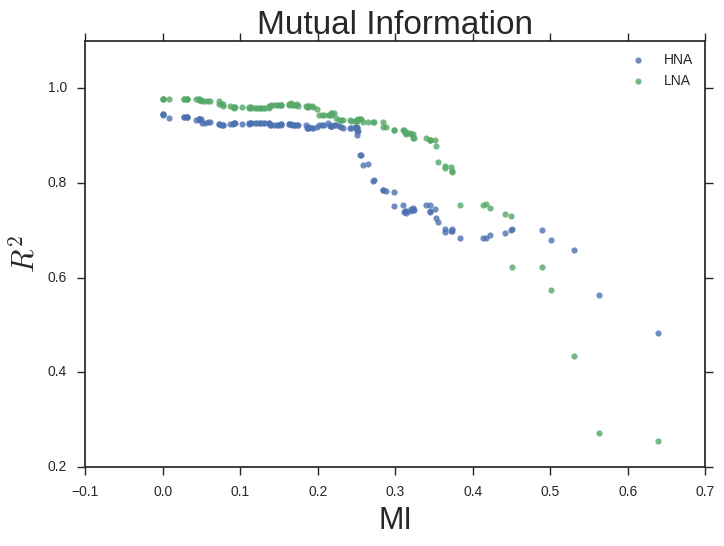

In [18]:
plt.figure()
sns.regplot(x=thr_otu_mi_hna,y=r2_otu_mi_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_mi_lna,y=r2_otu_mi_lna, fit_reg=False, label='LNA')
plt.xlabel('MI', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.title('Mutual Information', size=24)
plt.legend()
plt.show()

In [19]:
from analysis_functions import get_lassoCV_alpha

alpha = get_lassoCV_alpha(data_stand.loc[:,otus],hna,otus,cv)
    
otu_scores = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus], hna, alpha), index=otus, columns=['score'])
otu_scores.sort_values(ascending=False,inplace=True, by='score')

thr_otu_scores_hna, r2_otu_scores_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, otu_scores, cv)
thr_otu_scores_lna, r2_otu_scores_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, otu_scores, cv)

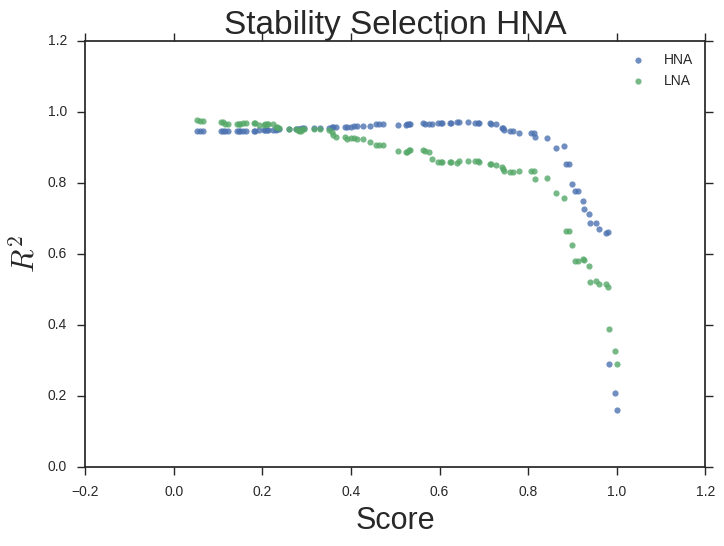

In [20]:
plt.figure()
sns.regplot(x=thr_otu_scores_hna,y=r2_otu_scores_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_scores_lna,y=r2_otu_scores_lna, fit_reg=False, label='LNA')
plt.xlabel('Score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.legend()
plt.title('Stability Selection HNA', size=24)
plt.show()

In [21]:
r2_final = r2_otu_scores_hna.max()
thr = thr_otu_scores_hna[r2_otu_scores_hna.argmax()]
print('R²_cv(hna): ' + str(r2_final) )
print('Threshold score: ' + str(thr))

R²_cv(hna): 0.970667036399
Threshold score: [ 0.66333333]


In [22]:
otu_scores = otu_scores.assign(abun_abs_mean = data_abs.loc[:,otus].mean())
otu_scores = otu_scores.assign(abun_abs_CV = data_abs.loc[:,otus].std()/data_abs.loc[:,otus].mean())
otu_scores =  otu_scores.assign(abun_rel_mean = data_rel.loc[:,otus].mean())
otu_scores = otu_scores.assign(abun_rel_CV = data_rel.loc[:,otus].std()/data_rel.loc[:,otus].mean())
otu_scores.to_csv('Final/hnascores_otus_abun0.001_rel.csv')

In [23]:
otu_scores_selected = otu_scores[otu_scores.score.values>thr]
selected_otus = otu_scores_selected.index
display(otu_scores_selected.head(10))
print('Size list selected OTUs: ' + str(len(selected_otus)))
#display(otu_scores_selected)

,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV
Otu000005,1.000000,132973.287096,1.819804,0.020487,1.602101
Otu000150,1.000000,7979.618737,2.609333,0.001764,3.292611
Otu000203,0.996667,6497.374081,2.170475,0.001132,2.031292
Otu000176,0.983333,7582.179430,1.454066,0.001477,1.095974
Otu000173,0.980000,8669.419742,1.883572,0.001220,1.630473
Otu000027,0.980000,24561.179681,1.194507,0.008951,1.158012
Otu000128,0.976667,4707.844430,1.684039,0.001592,1.755651
Otu000098,0.960000,10090.397718,1.683552,0.002155,1.513392
Otu000047,0.953333,19404.490287,2.128604,0.003984,1.963976
Otu000204,0.940000,5085.323088,2.505716,0.001204,2.519821


Size list selected OTUs: 42


In [24]:
print('R²_cv of HNA-selected OTUs in function of LNA: ' + str(r2_otu_scores_lna[r2_otu_scores_hna.argmax()]) )

R²_cv of HNA-selected OTUs in function of LNA: 0.86020638596


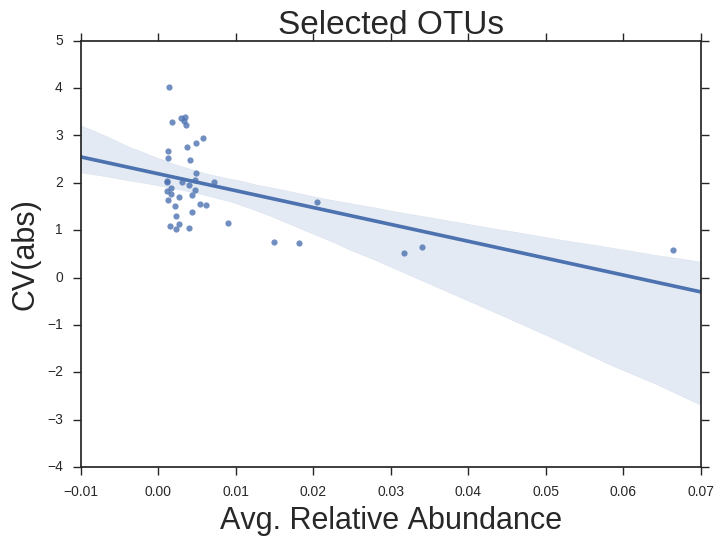

In [25]:
plt.figure()
sns.regplot(x='abun_rel_mean',y='abun_rel_CV', data=otu_scores_selected)
plt.xlabel('Avg. Relative Abundance', size=22)
plt.xticks(size=10)
plt.ylabel('CV(abs)', size=22)
plt.yticks(size=10)
plt.title('Selected OTUs', size=24)
plt.show()

In [26]:
#optimal_scores.to_csv('HNA_selectedOTUs_stand_abun_remov' + str(abun)+'_R2'+str(r2_final)+'.csv')

**Second goal**: Can we use the same pipeline to predict the _LNA_-counts? 

In [27]:
f_regr_lna, f_regr_p_lna = f_regression(data_stand.loc[:,otus],lna)
uni_fs_lna = pd.DataFrame(f_regr_lna, index=otus, columns = ['f_regr'])
uni_fs_lna['p-value'] = f_regr_p_lna
uni_fs_lna['mi'] = mutual_info_regression(data_stand.loc[:,otus],lna)
uni_fs_lna.sort_values(ascending=False,inplace=True, by='f_regr')
display(uni_fs_lna.head(10))

,f_regr,p-value,mi
Otu000010,275.257355,4.484375e-37,0.621645
Otu000026,260.618867,7.451850e-36,0.691075
Otu000060,182.330568,1.633596e-28,0.565247
Otu000009,173.908081,1.259757e-27,0.551806
Otu000020,157.185012,8.503227e-26,0.408835
Otu000016,149.902511,5.706270e-25,0.450590
Otu000029,135.211705,3.052463e-23,0.463250
Otu000053,134.977197,3.257826e-23,0.416113
Otu000001,128.763598,1.863985e-22,0.595522
Otu000007,118.304751,3.827869e-21,0.508392


In [28]:
uni_fs_selected_f_lna = uni_fs_lna[uni_fs_lna.loc[:,'p-value'].values < 0.05]
print('Number of selected OTUs with p < 0.05: ' + str(len(uni_fs_selected_f_lna)))
uni_fs_selected_f_lna = uni_fs_lna[uni_fs_lna.loc[:,'p-value'].values < 0.01]
print('Number of selected OTUs with p < 0.01: ' + str(len(uni_fs_selected_f_lna)))

Number of selected OTUs with p < 0.05: 87
Number of selected OTUs with p < 0.01: 81


In [29]:
thr_otu_f_regr_lna, r2_otu_f_regr_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs_lna['f_regr'], cv)
thr_otu_f_regr_hna, r2_otu_f_regr_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs_lna['f_regr'], cv)

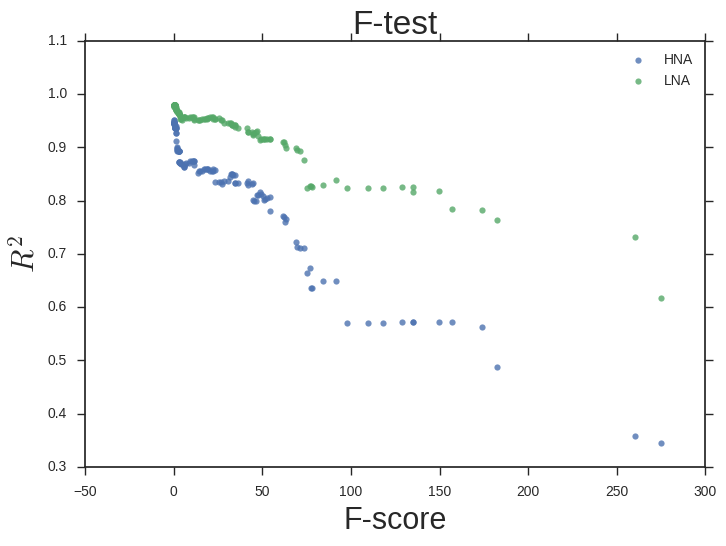

In [30]:
plt.figure()
sns.regplot(x=thr_otu_f_regr_hna,y=r2_otu_f_regr_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_f_regr_lna,y=r2_otu_f_regr_lna, fit_reg=False, label='LNA')
plt.xlabel('F-score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.title('F-test', size=24)
plt.legend()
plt.show()

In [31]:
alpha = get_lassoCV_alpha(data_stand.loc[:,otus],lna,otus,cv)
otu_scores_lna = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus], lna, alpha), index=otus, columns=['score'])
otu_scores_lna.sort_values(ascending=False, inplace=True, by='score')

thr_otu_scores_lna, r2_otu_scores_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, otu_scores_lna, cv)
thr_otu_scores_hna, r2_otu_scores_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, otu_scores_lna, cv)

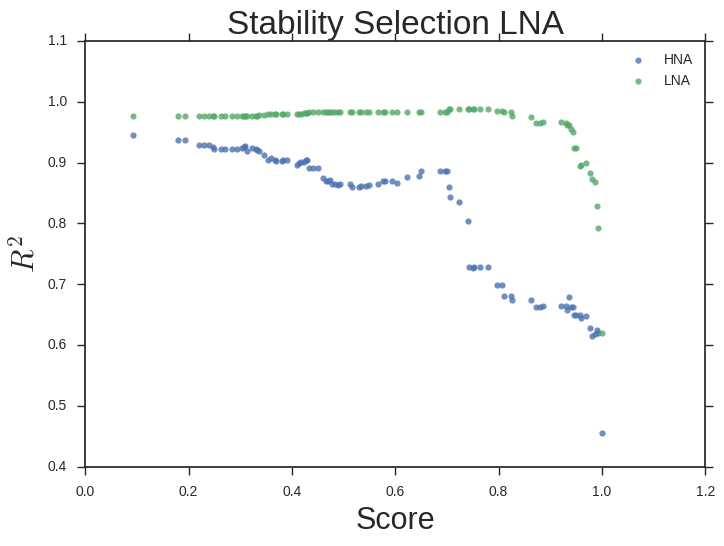

In [32]:
plt.figure()
sns.regplot(x=thr_otu_scores_hna,y=r2_otu_scores_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_scores_lna,y=r2_otu_scores_lna, fit_reg=False, label='LNA')
plt.xlabel('Score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.legend()
plt.title('Stability Selection LNA', size=24)
plt.show()

In [33]:
r2_final = r2_otu_scores_lna.max()
thr_lna = thr_otu_scores_lna[r2_otu_scores_lna.argmax()]
print('R²_cv(lna): ' + str(r2_final) )
print('Threshold score: ' + str(thr_lna))

R²_cv(lna): 0.988459017261
Threshold score: [ 0.74]


In [34]:
otu_scores_lna = otu_scores_lna.assign(abun_abs_mean = data_abs.loc[:,otus].mean())
otu_scores_lna = otu_scores_lna.assign(abun_abs_CV = data_abs.loc[:,otus].std()/data_abs.loc[:,otus].mean())
otu_scores_lna =  otu_scores_lna.assign(abun_rel_mean = data_rel.loc[:,otus].mean())
otu_scores_lna = otu_scores_lna.assign(abun_rel_CV = data_rel.loc[:,otus].std()/data_rel.loc[:,otus].mean())
otu_scores_lna.to_csv('Final/lnascores_otus_abun0.001_rel.csv')

In [35]:
otu_scores_selected_lna = otu_scores_lna[otu_scores_lna.score.values>thr]
selected_otus_lna = otu_scores_selected_lna.index
print('Size list selected OTUs: ' + str(len(selected_otus_lna)))
display(otu_scores_selected_lna.head(10))

Size list selected OTUs: 59


,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV
Otu000022,1.000000,46093.611021,1.530803,0.015121,2.118543
Otu000005,1.000000,132973.287096,1.819804,0.020487,1.602101
Otu000007,1.000000,124358.796053,0.821328,0.027377,0.631862
Otu000023,1.000000,38809.752650,1.292218,0.007387,1.418479
Otu000001,0.993333,369375.389384,0.728759,0.094853,0.638430
Otu000004,0.993333,315529.656001,0.929570,0.066357,0.586675
Otu000128,0.993333,4707.844430,1.684039,0.001592,1.755651
Otu000078,0.990000,30006.232233,1.598847,0.004496,1.511875
Otu000284,0.986667,10321.717872,3.418887,0.001210,3.084120
Otu000110,0.986667,7350.406216,4.063507,0.005350,5.169109


In [36]:
print('R²_cv of LNA-selected OTUs in function of HNA: ' + str(r2_otu_scores_hna[r2_otu_scores_lna.argmax()]) )

R²_cv of LNA-selected OTUs in function of HNA: 0.804516062099


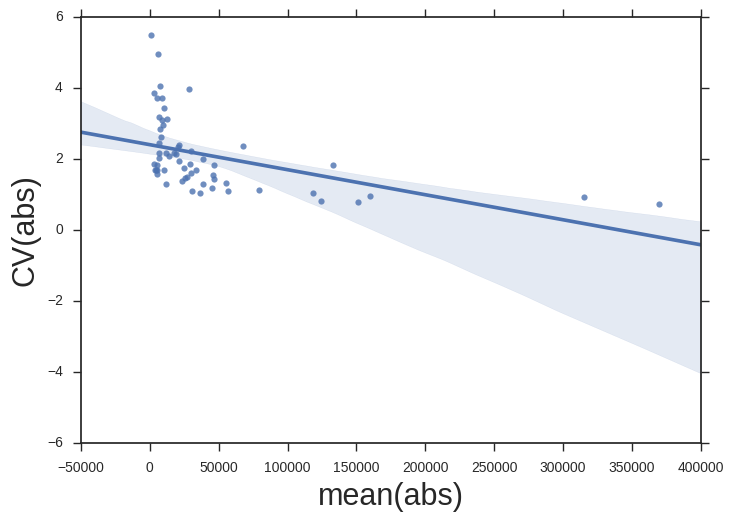

In [37]:
plt.figure()
sns.regplot(x='abun_abs_mean',y='abun_abs_CV', data=otu_scores_selected_lna)
plt.xlabel('mean(abs)', size=22)
plt.xticks(size=10)
plt.ylabel('CV(abs)', size=22)
plt.yticks(size=10)
plt.show()

Let's compare the HNA- and LNA-lists, which OTU's are shared (_common_) and which are only part of the HNA- or LNA subset?: 

In [38]:
idx_hna = otu_scores_selected.index.difference(otu_scores_selected_lna.index)
idx_lna = otu_scores_selected_lna.index.difference(otu_scores_selected.index)
idx_common = otu_scores_selected.drop(idx_hna).index
pd.Series(idx_common).to_csv('commonOTU_HNALNA_abun.001_rel.csv')
print('Size subset OTUs only related to HNA: ' + str(len(idx_hna)) + '; opposed to total size: ' + str(len(otu_scores_selected)))
print('Size subset OTUs only related to LNA: ' + str(len(idx_lna)) + '; opposed to total size: ' + str(len(otu_scores_selected_lna)))
print('Size subset OTUs related to both: ' + str(len(idx_common)))

display(otu_scores_selected_lna.loc[idx_common,:])
#data_abs_raw = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
#data_abs_raw = data_abs_raw.loc[index,:]
#display(data_abs_raw.loc[:,idx_hna].sum(axis=1).values/hna.values)

Size subset OTUs only related to HNA: 26; opposed to total size: 42
Size subset OTUs only related to LNA: 43; opposed to total size: 59
Size subset OTUs related to both: 16


,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV
Otu000005,1.000000,132973.287096,1.819804,0.020487,1.602101
Otu000150,0.823333,7979.618737,2.609333,0.001764,3.292611
Otu000203,0.723333,6497.374081,2.170475,0.001132,2.031292
Otu000128,0.993333,4707.844430,1.684039,0.001592,1.755651
Otu000098,0.700000,10090.397718,1.683552,0.002155,1.513392
Otu000047,0.703333,19404.490287,2.128604,0.003984,1.963976
Otu000063,0.686667,8945.606345,3.083413,0.003479,3.391339
Otu000070,0.703333,17642.716358,2.161505,0.005771,2.938492
Otu000009,0.930000,150958.577254,0.788330,0.031635,0.507992
Otu000040,0.976667,24506.495983,1.729165,0.004292,1.739501


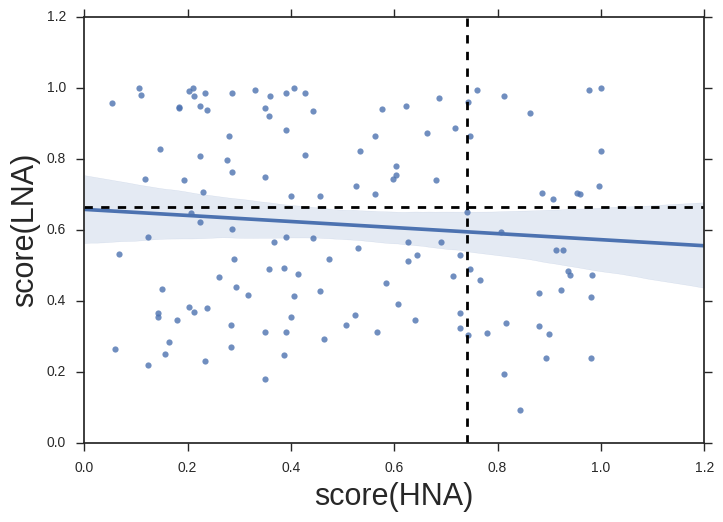

In [39]:
plt.figure()
sns.regplot(x=otu_scores.loc[:,'score'],y=otu_scores_lna.loc[otu_scores.index,'score'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('score(LNA)', size=22)
plt.yticks(size=10)
plt.axhline(y=thr, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr_lna, linewidth=2, linestyle='--', color = 'k')
plt.show()

This figure shows 4 area's: 
- (left top corner): OTU's selected solely in function of **LNA**-dynamics, 
- (right top corner): OTU's selected in function of both **HNA**- and **LNA**-dynamics, 
- (left bottom corner): OTU's that are _not_ selected, 
- (right bottom corner): OTU's selected solely in function of **HNA**-dynamics. 

Univariate vs. Stability selection

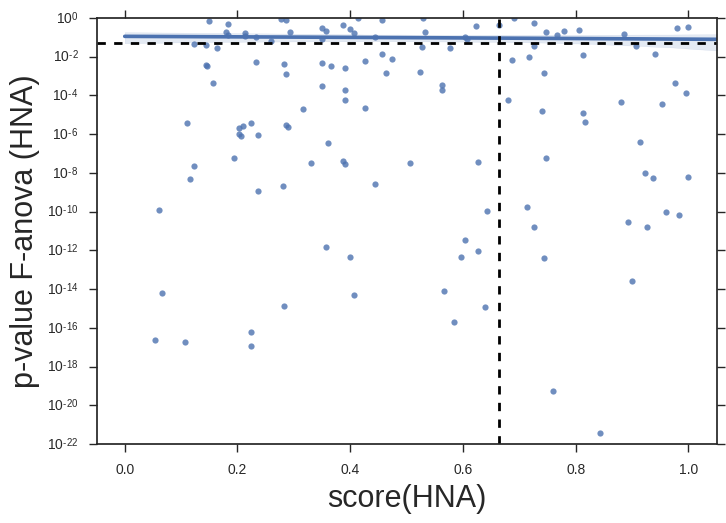

In [40]:
plt.figure()
sns.regplot(x=otu_scores.loc[:,'score'],y=uni_fs.loc[otu_scores.index,'p-value'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('p-value F-anova (HNA)', size=22)
plt.yticks(size=10)
plt.yscale('log')
plt.axhline(y=0.05, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr, linewidth=2, linestyle='--', color = 'k')
plt.axis([-0.05,1.05,0.0000000000000000000001, 1])
plt.show()

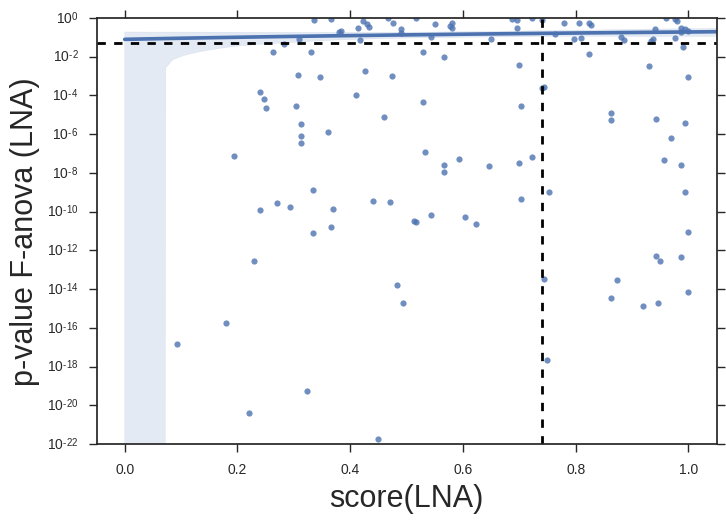

In [41]:
plt.figure()
sns.regplot(x=otu_scores_lna.loc[:,'score'],y=uni_fs_lna.loc[otu_scores.index,'p-value'])
plt.xlabel('score(LNA)', size=22)
plt.xticks(size=10)
plt.ylabel('p-value F-anova (LNA)', size=22)
plt.yticks(size=10)
plt.yscale('log')
plt.axhline(y=0.05, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr_lna, linewidth=2, linestyle='--', color = 'k')
plt.axis([-0.05,1.05,0.0000000000000000000001, 1])
plt.show()

This analysis shows that the HNA/LNA dynamics cannot solely be attributed to OTU's that are present in the respective cloud; this is also clear from the mutual correlation between HNA- and LNA-counts ( $\rho(\text{HNA,LNA}) = 0.75$ ). 

I see two reasons for this: 
- Some OTU's are simply present in the two clouds; 
- Some HNA-OTU's interact with LNA-OTU's and vice versa. 